In [1]:
api_key = '08LTQ7UV6OYHKN5S' # alpha-vantage

In [2]:
ticker = "BTC-USD"

In [3]:
import yfinance as yf
import pandas as pd

def get_stock_data(stock_name, start_date, end_date, interval='1d'):
    try:
        df = yf.download(stock_name, start=start_date, end=end_date, interval=interval)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [4]:
stock_data = get_stock_data(ticker, "2025-03-11", "2025-03-15", '1m')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
row_counts = stock_data.resample("D").size()
row_counts

,0
Datetime,
2025-03-11 00:00:00+00:00,1085
2025-03-12 00:00:00+00:00,1072
2025-03-13 00:00:00+00:00,1060
2025-03-14 00:00:00+00:00,1064


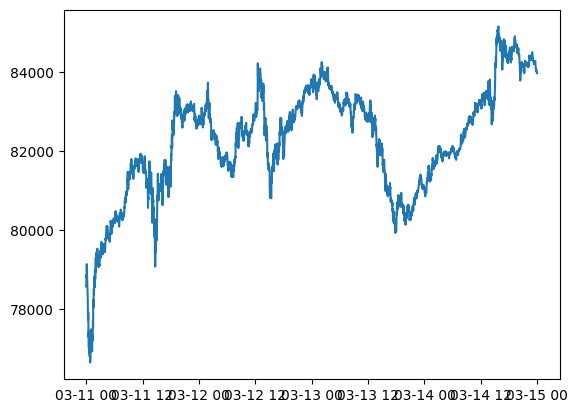

In [6]:
import matplotlib.pyplot as plt

plt.plot(stock_data['Close'])

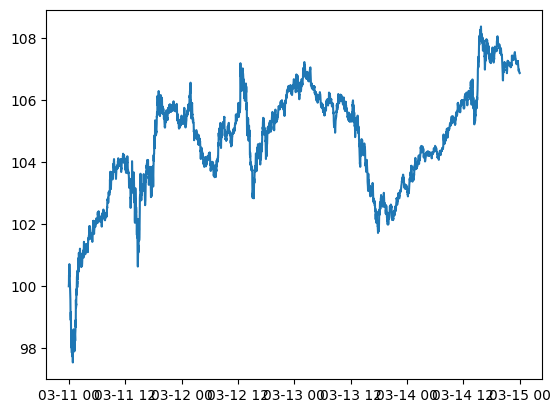

In [7]:
plt.plot(stock_data['Close'] / stock_data['Close'].iloc[0] * 100)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
stock_data.columns

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [10]:
stock_data.columns = ['_'.join(col) for col in stock_data.columns]
stock_pcts = stock_data.pct_change()
stock_pcts_res = stock_pcts.iloc[1:]
means, stds = stock_pcts_res.mean(), stock_pcts_res.std()
stock_pcts_res_norm = (stock_pcts_res - means) / stds
stock_pcts_res_norm.drop(f'Volume_{ticker}', axis=1, inplace=True) # NaN values

In [11]:
class BaselineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2, breed='GRU'):
        super(BaselineRNN, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True) if breed == 'GRU' else nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.SiLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.GRU) or isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if "weight_ih" in name:  # Input-hidden weights
                    nn.init.xavier_uniform_(param)
                elif "weight_hh" in name:  # Hidden-hidden weights
                    nn.init.orthogonal_(param)
                elif "bias" in name:  # Bias terms
                    nn.init.zeros_(param)
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='linear')
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x):
        # x shape: (seq_len, batch_size, input_size)
        out, h_n = self.rnn(x)  # out.shape = (batch_size, seq_len, hidden_size)
        out = self.fc1(out) # out.shape = (batch_size, seq_len, hidden_size)
        out = self.fc2(self.act(out))  # out.shape = (batch_size, seq_len, output_size)
        return out

In [12]:
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import trange, tqdm

class MyDataset(Dataset):
    def __init__(self, data, seq_len, device='cpu'):
        self.data = data
        self.seq_len = seq_len
        self.device = device

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        idx = idx % len(self)
        X = self.data[idx: idx + self.seq_len]
        y= self.data[idx + 1: idx + self.seq_len + 1]
        return torch.tensor(X, dtype=torch.float32, device=self.device), torch.tensor(y, dtype=torch.float32, device=self.device)

In [13]:
SEQ_LEN = 700
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
PARTITION = 0.8

val_idx, actual_val_pred_idx = 1000, 300
data = stock_pcts_res_norm[:-val_idx].values

In [14]:
dataset = MyDataset(data, SEQ_LEN, DEVICE)

len(dataset)

train_size, test_size = int(len(dataset) * PARTITION), len(dataset) - int(len(dataset) * PARTITION)
training_data, testing_data = random_split(dataset, [train_size, test_size])

print(len(training_data))

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE)

NUM_LAYERS = 2
HID_DIM = 64
DROPOUT = 0.5
LR = 1e-4
NB_EPOCHS = 200
COEF = 0.5

2064


In [15]:
def train(input_size, hidden_size, output_size, num_layers, dropout, breed):
    input_size = data.shape[1]
    hidden_size = HID_DIM
    output_size = data.shape[1]
    num_layers = NUM_LAYERS
    dropout = DROPOUT

    model = BaselineRNN(input_size, hidden_size, output_size, num_layers, dropout, breed).to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters())

    best_val_loss = float('inf')

    pbar = tqdm(range(NB_EPOCHS), desc="Epochs", unit="epoch", leave=True)
    for epoch in pbar:
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss = running_loss * (1 - COEF) + loss.item() * COEF

        test_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                test_loss = test_loss * (1 - COEF) + criterion(output, y_batch).item() * COEF

        pbar.set_postfix({'Train Loss': f'{running_loss:.4f}', 'Val Loss': f'{test_loss:.4f}'})
        # Checkpoint if validation loss improves
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save(model.state_dict(), f'best_model_{breed}.pth')
            print(f"\nModel saved at epoch {epoch+1} with val_loss: {test_loss:.4f}")

In [16]:
for breed in ['GRU', 'LSTM']:
    train(data.shape[1], HID_DIM, data.shape[1], NUM_LAYERS, DROPOUT, breed)

Epochs:   0%|          | 1/200 [00:01<04:35,  1.38s/epoch, Train Loss=1.1284, Val Loss=1.1238]


Model saved at epoch 1 with val_loss: 1.1238


Epochs:   1%|          | 2/200 [00:02<03:23,  1.03s/epoch, Train Loss=1.0111, Val Loss=0.9663]


Model saved at epoch 2 with val_loss: 0.9663


Epochs:   2%|▏         | 3/200 [00:03<03:23,  1.03s/epoch, Train Loss=0.8966, Val Loss=0.8234]


Model saved at epoch 3 with val_loss: 0.8234


Epochs:   2%|▏         | 4/200 [00:04<03:31,  1.08s/epoch, Train Loss=0.7913, Val Loss=0.7192]


Model saved at epoch 4 with val_loss: 0.7192


Epochs:   2%|▎         | 5/200 [00:05<03:09,  1.03epoch/s, Train Loss=0.6926, Val Loss=0.6106]


Model saved at epoch 5 with val_loss: 0.6106


Epochs:   3%|▎         | 6/200 [00:05<02:43,  1.19epoch/s, Train Loss=0.6019, Val Loss=0.5224]


Model saved at epoch 6 with val_loss: 0.5224


Epochs:   4%|▎         | 7/200 [00:06<02:26,  1.32epoch/s, Train Loss=0.5318, Val Loss=0.4540]


Model saved at epoch 7 with val_loss: 0.4540


Epochs:   4%|▍         | 8/200 [00:06<02:14,  1.43epoch/s, Train Loss=0.4845, Val Loss=0.4016]


Model saved at epoch 8 with val_loss: 0.4016


Epochs:   4%|▍         | 9/200 [00:07<02:08,  1.49epoch/s, Train Loss=0.4437, Val Loss=0.3676]


Model saved at epoch 9 with val_loss: 0.3676


Epochs:   5%|▌         | 10/200 [00:08<02:07,  1.49epoch/s, Train Loss=0.4107, Val Loss=0.3357]


Model saved at epoch 10 with val_loss: 0.3357


Epochs:   6%|▌         | 11/200 [00:08<02:05,  1.50epoch/s, Train Loss=0.3820, Val Loss=0.3100]


Model saved at epoch 11 with val_loss: 0.3100


Epochs:   6%|▌         | 12/200 [00:09<02:05,  1.50epoch/s, Train Loss=0.3601, Val Loss=0.2902]


Model saved at epoch 12 with val_loss: 0.2902


Epochs:   6%|▋         | 13/200 [00:10<02:00,  1.55epoch/s, Train Loss=0.3386, Val Loss=0.2705]


Model saved at epoch 13 with val_loss: 0.2705


Epochs:   7%|▋         | 14/200 [00:10<01:57,  1.58epoch/s, Train Loss=0.3202, Val Loss=0.2536]


Model saved at epoch 14 with val_loss: 0.2536


Epochs:   8%|▊         | 15/200 [00:11<01:54,  1.62epoch/s, Train Loss=0.3041, Val Loss=0.2385]


Model saved at epoch 15 with val_loss: 0.2385


Epochs:   8%|▊         | 16/200 [00:11<01:52,  1.64epoch/s, Train Loss=0.2918, Val Loss=0.2253]


Model saved at epoch 16 with val_loss: 0.2253


Epochs:   8%|▊         | 17/200 [00:12<01:50,  1.66epoch/s, Train Loss=0.2816, Val Loss=0.2106]


Model saved at epoch 17 with val_loss: 0.2106


Epochs:   9%|▉         | 18/200 [00:13<01:49,  1.67epoch/s, Train Loss=0.2672, Val Loss=0.2000]


Model saved at epoch 18 with val_loss: 0.2000


Epochs:  10%|▉         | 19/200 [00:13<01:47,  1.68epoch/s, Train Loss=0.2569, Val Loss=0.1871]


Model saved at epoch 19 with val_loss: 0.1871


Epochs:  10%|█         | 20/200 [00:14<01:46,  1.69epoch/s, Train Loss=0.2466, Val Loss=0.1775]


Model saved at epoch 20 with val_loss: 0.1775


Epochs:  10%|█         | 21/200 [00:14<01:50,  1.63epoch/s, Train Loss=0.2344, Val Loss=0.1679]


Model saved at epoch 21 with val_loss: 0.1679


Epochs:  11%|█         | 22/200 [00:15<01:48,  1.65epoch/s, Train Loss=0.2242, Val Loss=0.1603]


Model saved at epoch 22 with val_loss: 0.1603


Epochs:  12%|█▏        | 23/200 [00:16<01:46,  1.66epoch/s, Train Loss=0.2165, Val Loss=0.1518]


Model saved at epoch 23 with val_loss: 0.1518


Epochs:  12%|█▏        | 24/200 [00:16<01:45,  1.67epoch/s, Train Loss=0.2104, Val Loss=0.1458]


Model saved at epoch 24 with val_loss: 0.1458


Epochs:  12%|█▎        | 25/200 [00:17<01:44,  1.68epoch/s, Train Loss=0.2048, Val Loss=0.1377]


Model saved at epoch 25 with val_loss: 0.1377


Epochs:  13%|█▎        | 26/200 [00:17<01:43,  1.69epoch/s, Train Loss=0.1966, Val Loss=0.1317]


Model saved at epoch 26 with val_loss: 0.1317


Epochs:  14%|█▎        | 27/200 [00:18<01:42,  1.69epoch/s, Train Loss=0.1905, Val Loss=0.1290]


Model saved at epoch 27 with val_loss: 0.1290


Epochs:  14%|█▍        | 28/200 [00:18<01:41,  1.70epoch/s, Train Loss=0.1857, Val Loss=0.1212]


Model saved at epoch 28 with val_loss: 0.1212


Epochs:  14%|█▍        | 29/200 [00:19<01:42,  1.66epoch/s, Train Loss=0.1801, Val Loss=0.1158]


Model saved at epoch 29 with val_loss: 0.1158


Epochs:  15%|█▌        | 30/200 [00:20<01:45,  1.61epoch/s, Train Loss=0.1751, Val Loss=0.1117]


Model saved at epoch 30 with val_loss: 0.1117


Epochs:  16%|█▌        | 31/200 [00:20<01:47,  1.57epoch/s, Train Loss=0.1721, Val Loss=0.1072]


Model saved at epoch 31 with val_loss: 0.1072


Epochs:  16%|█▌        | 32/200 [00:21<01:47,  1.56epoch/s, Train Loss=0.1654, Val Loss=0.1059]


Model saved at epoch 32 with val_loss: 0.1059


Epochs:  16%|█▋        | 33/200 [00:22<01:44,  1.59epoch/s, Train Loss=0.1604, Val Loss=0.0992]


Model saved at epoch 33 with val_loss: 0.0992


Epochs:  17%|█▋        | 34/200 [00:22<01:42,  1.62epoch/s, Train Loss=0.1571, Val Loss=0.0967]


Model saved at epoch 34 with val_loss: 0.0967


Epochs:  18%|█▊        | 35/200 [00:23<01:40,  1.64epoch/s, Train Loss=0.1527, Val Loss=0.0941]


Model saved at epoch 35 with val_loss: 0.0941


Epochs:  18%|█▊        | 36/200 [00:24<01:39,  1.64epoch/s, Train Loss=0.1505, Val Loss=0.0915]


Model saved at epoch 36 with val_loss: 0.0915


Epochs:  18%|█▊        | 37/200 [00:24<01:38,  1.65epoch/s, Train Loss=0.1454, Val Loss=0.0884]


Model saved at epoch 37 with val_loss: 0.0884


Epochs:  19%|█▉        | 38/200 [00:25<01:37,  1.66epoch/s, Train Loss=0.1439, Val Loss=0.0854]


Model saved at epoch 38 with val_loss: 0.0854


Epochs:  20%|█▉        | 39/200 [00:25<01:36,  1.67epoch/s, Train Loss=0.1385, Val Loss=0.0834]


Model saved at epoch 39 with val_loss: 0.0834


Epochs:  20%|██        | 40/200 [00:26<01:35,  1.68epoch/s, Train Loss=0.1361, Val Loss=0.0826]


Model saved at epoch 40 with val_loss: 0.0826


Epochs:  20%|██        | 41/200 [00:26<01:34,  1.68epoch/s, Train Loss=0.1345, Val Loss=0.0810]


Model saved at epoch 41 with val_loss: 0.0810


Epochs:  21%|██        | 42/200 [00:27<01:33,  1.69epoch/s, Train Loss=0.1324, Val Loss=0.0767]


Model saved at epoch 42 with val_loss: 0.0767


Epochs:  22%|██▏       | 43/200 [00:28<01:32,  1.70epoch/s, Train Loss=0.1280, Val Loss=0.0762]


Model saved at epoch 43 with val_loss: 0.0762


Epochs:  22%|██▏       | 44/200 [00:28<01:31,  1.70epoch/s, Train Loss=0.1270, Val Loss=0.0749]


Model saved at epoch 44 with val_loss: 0.0749


Epochs:  22%|██▎       | 45/200 [00:29<01:31,  1.70epoch/s, Train Loss=0.1228, Val Loss=0.0715]


Model saved at epoch 45 with val_loss: 0.0715


Epochs:  23%|██▎       | 46/200 [00:29<01:30,  1.70epoch/s, Train Loss=0.1217, Val Loss=0.0714]


Model saved at epoch 46 with val_loss: 0.0714


Epochs:  24%|██▎       | 47/200 [00:30<01:29,  1.70epoch/s, Train Loss=0.1201, Val Loss=0.0700]


Model saved at epoch 47 with val_loss: 0.0700


Epochs:  24%|██▍       | 48/200 [00:31<01:29,  1.70epoch/s, Train Loss=0.1177, Val Loss=0.0679]


Model saved at epoch 48 with val_loss: 0.0679


Epochs:  24%|██▍       | 49/200 [00:31<01:31,  1.65epoch/s, Train Loss=0.1168, Val Loss=0.0667]


Model saved at epoch 49 with val_loss: 0.0667


Epochs:  25%|██▌       | 50/200 [00:32<01:33,  1.60epoch/s, Train Loss=0.1141, Val Loss=0.0653]


Model saved at epoch 50 with val_loss: 0.0653


Epochs:  26%|██▌       | 51/200 [00:33<01:34,  1.58epoch/s, Train Loss=0.1105, Val Loss=0.0633]


Model saved at epoch 51 with val_loss: 0.0633


Epochs:  26%|██▋       | 53/200 [00:34<01:31,  1.60epoch/s, Train Loss=0.1082, Val Loss=0.0615]


Model saved at epoch 53 with val_loss: 0.0615


Epochs:  27%|██▋       | 54/200 [00:34<01:29,  1.64epoch/s, Train Loss=0.1038, Val Loss=0.0590]


Model saved at epoch 54 with val_loss: 0.0590


Epochs:  28%|██▊       | 56/200 [00:36<01:26,  1.67epoch/s, Train Loss=0.1017, Val Loss=0.0570]


Model saved at epoch 56 with val_loss: 0.0570


Epochs:  29%|██▉       | 58/200 [00:37<01:23,  1.70epoch/s, Train Loss=0.0987, Val Loss=0.0561]


Model saved at epoch 58 with val_loss: 0.0561


Epochs:  30%|██▉       | 59/200 [00:37<01:22,  1.71epoch/s, Train Loss=0.0978, Val Loss=0.0545]


Model saved at epoch 59 with val_loss: 0.0545


Epochs:  30%|███       | 61/200 [00:38<01:20,  1.72epoch/s, Train Loss=0.0954, Val Loss=0.0523]


Model saved at epoch 61 with val_loss: 0.0523


Epochs:  31%|███       | 62/200 [00:39<01:20,  1.72epoch/s, Train Loss=0.0925, Val Loss=0.0519]


Model saved at epoch 62 with val_loss: 0.0519


Epochs:  32%|███▏      | 63/200 [00:40<01:19,  1.72epoch/s, Train Loss=0.0924, Val Loss=0.0513]


Model saved at epoch 63 with val_loss: 0.0513


Epochs:  32%|███▏      | 64/200 [00:40<01:18,  1.72epoch/s, Train Loss=0.0913, Val Loss=0.0510]


Model saved at epoch 64 with val_loss: 0.0510


Epochs:  32%|███▎      | 65/200 [00:41<01:18,  1.72epoch/s, Train Loss=0.0913, Val Loss=0.0503]


Model saved at epoch 65 with val_loss: 0.0503


Epochs:  33%|███▎      | 66/200 [00:41<01:18,  1.72epoch/s, Train Loss=0.0896, Val Loss=0.0484]


Model saved at epoch 66 with val_loss: 0.0484


Epochs:  34%|███▎      | 67/200 [00:42<01:17,  1.71epoch/s, Train Loss=0.0888, Val Loss=0.0481]


Model saved at epoch 67 with val_loss: 0.0481


Epochs:  34%|███▍      | 68/200 [00:42<01:16,  1.72epoch/s, Train Loss=0.0884, Val Loss=0.0476]


Model saved at epoch 68 with val_loss: 0.0476


Epochs:  34%|███▍      | 69/200 [00:43<01:16,  1.72epoch/s, Train Loss=0.0862, Val Loss=0.0467]


Model saved at epoch 69 with val_loss: 0.0467


Epochs:  35%|███▌      | 70/200 [00:44<01:18,  1.66epoch/s, Train Loss=0.0840, Val Loss=0.0462]


Model saved at epoch 70 with val_loss: 0.0462


Epochs:  36%|███▌      | 71/200 [00:44<01:19,  1.63epoch/s, Train Loss=0.0845, Val Loss=0.0460]


Model saved at epoch 71 with val_loss: 0.0460


Epochs:  36%|███▌      | 72/200 [00:45<01:21,  1.57epoch/s, Train Loss=0.0831, Val Loss=0.0447]


Model saved at epoch 72 with val_loss: 0.0447


Epochs:  38%|███▊      | 75/200 [00:47<01:15,  1.67epoch/s, Train Loss=0.0805, Val Loss=0.0435]


Model saved at epoch 75 with val_loss: 0.0435


Epochs:  38%|███▊      | 76/200 [00:47<01:13,  1.68epoch/s, Train Loss=0.0808, Val Loss=0.0431]


Model saved at epoch 76 with val_loss: 0.0431


Epochs:  38%|███▊      | 77/200 [00:48<01:12,  1.70epoch/s, Train Loss=0.0798, Val Loss=0.0429]


Model saved at epoch 77 with val_loss: 0.0429


Epochs:  40%|████      | 80/200 [00:50<01:09,  1.72epoch/s, Train Loss=0.0777, Val Loss=0.0420]


Model saved at epoch 80 with val_loss: 0.0420


Epochs:  41%|████      | 82/200 [00:51<01:08,  1.72epoch/s, Train Loss=0.0742, Val Loss=0.0404]


Model saved at epoch 82 with val_loss: 0.0404


Epochs:  42%|████▏     | 84/200 [00:52<01:07,  1.72epoch/s, Train Loss=0.0739, Val Loss=0.0403]


Model saved at epoch 84 with val_loss: 0.0403


Epochs:  42%|████▎     | 85/200 [00:53<01:06,  1.72epoch/s, Train Loss=0.0725, Val Loss=0.0402]


Model saved at epoch 85 with val_loss: 0.0402


Epochs:  44%|████▎     | 87/200 [00:54<01:06,  1.71epoch/s, Train Loss=0.0730, Val Loss=0.0396]


Model saved at epoch 87 with val_loss: 0.0396


Epochs:  44%|████▍     | 88/200 [00:54<01:05,  1.71epoch/s, Train Loss=0.0717, Val Loss=0.0390]


Model saved at epoch 88 with val_loss: 0.0390


Epochs:  44%|████▍     | 89/200 [00:55<01:04,  1.72epoch/s, Train Loss=0.0701, Val Loss=0.0389]


Model saved at epoch 89 with val_loss: 0.0389


Epochs:  46%|████▌     | 91/200 [00:56<01:07,  1.62epoch/s, Train Loss=0.0700, Val Loss=0.0381]


Model saved at epoch 91 with val_loss: 0.0381


Epochs:  46%|████▌     | 92/200 [00:57<01:08,  1.58epoch/s, Train Loss=0.0689, Val Loss=0.0377]


Model saved at epoch 92 with val_loss: 0.0377


Epochs:  47%|████▋     | 94/200 [00:58<01:05,  1.62epoch/s, Train Loss=0.0686, Val Loss=0.0367]


Model saved at epoch 94 with val_loss: 0.0367


Epochs:  48%|████▊     | 97/200 [01:00<01:00,  1.69epoch/s, Train Loss=0.0661, Val Loss=0.0361]


Model saved at epoch 97 with val_loss: 0.0361


Epochs:  50%|█████     | 100/200 [01:02<00:58,  1.72epoch/s, Train Loss=0.0654, Val Loss=0.0356]


Model saved at epoch 100 with val_loss: 0.0356


Epochs:  50%|█████     | 101/200 [01:02<00:57,  1.72epoch/s, Train Loss=0.0655, Val Loss=0.0353]


Model saved at epoch 101 with val_loss: 0.0353


Epochs:  51%|█████     | 102/200 [01:03<00:56,  1.72epoch/s, Train Loss=0.0643, Val Loss=0.0346]


Model saved at epoch 102 with val_loss: 0.0346


Epochs:  52%|█████▏    | 103/200 [01:03<00:56,  1.73epoch/s, Train Loss=0.0632, Val Loss=0.0345]


Model saved at epoch 103 with val_loss: 0.0345


Epochs:  52%|█████▏    | 104/200 [01:04<00:55,  1.72epoch/s, Train Loss=0.0628, Val Loss=0.0345]


Model saved at epoch 104 with val_loss: 0.0345


Epochs:  53%|█████▎    | 106/200 [01:05<00:54,  1.72epoch/s, Train Loss=0.0624, Val Loss=0.0344]


Model saved at epoch 106 with val_loss: 0.0344


Epochs:  54%|█████▎    | 107/200 [01:06<00:54,  1.72epoch/s, Train Loss=0.0609, Val Loss=0.0343]


Model saved at epoch 107 with val_loss: 0.0343


Epochs:  54%|█████▍    | 108/200 [01:06<00:53,  1.73epoch/s, Train Loss=0.0615, Val Loss=0.0332]


Model saved at epoch 108 with val_loss: 0.0332


Epochs:  55%|█████▌    | 110/200 [01:07<00:52,  1.70epoch/s, Train Loss=0.0602, Val Loss=0.0328]


Model saved at epoch 110 with val_loss: 0.0328


Epochs:  56%|█████▋    | 113/200 [01:09<00:54,  1.59epoch/s, Train Loss=0.0589, Val Loss=0.0326]


Model saved at epoch 113 with val_loss: 0.0326


Epochs:  57%|█████▋    | 114/200 [01:10<00:52,  1.63epoch/s, Train Loss=0.0596, Val Loss=0.0323]


Model saved at epoch 114 with val_loss: 0.0323


Epochs:  57%|█████▊    | 115/200 [01:11<00:51,  1.66epoch/s, Train Loss=0.0583, Val Loss=0.0322]


Model saved at epoch 115 with val_loss: 0.0322


Epochs:  58%|█████▊    | 117/200 [01:12<00:49,  1.69epoch/s, Train Loss=0.0565, Val Loss=0.0317]


Model saved at epoch 117 with val_loss: 0.0317


Epochs:  60%|█████▉    | 119/200 [01:13<00:48,  1.68epoch/s, Train Loss=0.0573, Val Loss=0.0316]


Model saved at epoch 119 with val_loss: 0.0316


Epochs:  60%|██████    | 120/200 [01:13<00:47,  1.69epoch/s, Train Loss=0.0568, Val Loss=0.0313]


Model saved at epoch 120 with val_loss: 0.0313


Epochs:  60%|██████    | 121/200 [01:14<00:46,  1.69epoch/s, Train Loss=0.0572, Val Loss=0.0312]


Model saved at epoch 121 with val_loss: 0.0312


Epochs:  61%|██████    | 122/200 [01:15<00:45,  1.70epoch/s, Train Loss=0.0563, Val Loss=0.0310]


Model saved at epoch 122 with val_loss: 0.0310


Epochs:  62%|██████▏   | 124/200 [01:16<00:44,  1.71epoch/s, Train Loss=0.0555, Val Loss=0.0308]


Model saved at epoch 124 with val_loss: 0.0308


Epochs:  62%|██████▎   | 125/200 [01:16<00:43,  1.71epoch/s, Train Loss=0.0557, Val Loss=0.0307]


Model saved at epoch 125 with val_loss: 0.0307


Epochs:  64%|██████▎   | 127/200 [01:18<00:42,  1.72epoch/s, Train Loss=0.0553, Val Loss=0.0306]


Model saved at epoch 127 with val_loss: 0.0306


Epochs:  64%|██████▍   | 129/200 [01:19<00:41,  1.72epoch/s, Train Loss=0.0529, Val Loss=0.0299]


Model saved at epoch 129 with val_loss: 0.0299


Epochs:  66%|██████▋   | 133/200 [01:21<00:42,  1.57epoch/s, Train Loss=0.0534, Val Loss=0.0293]


Model saved at epoch 133 with val_loss: 0.0293


Epochs:  68%|██████▊   | 135/200 [01:22<00:39,  1.64epoch/s, Train Loss=0.0523, Val Loss=0.0292]


Model saved at epoch 135 with val_loss: 0.0292


Epochs:  68%|██████▊   | 136/200 [01:23<00:38,  1.66epoch/s, Train Loss=0.0523, Val Loss=0.0290]


Model saved at epoch 136 with val_loss: 0.0290


Epochs:  70%|███████   | 141/200 [01:26<00:34,  1.72epoch/s, Train Loss=0.0508, Val Loss=0.0285]


Model saved at epoch 141 with val_loss: 0.0285


Epochs:  72%|███████▎  | 145/200 [01:28<00:31,  1.72epoch/s, Train Loss=0.0495, Val Loss=0.0284]


Model saved at epoch 145 with val_loss: 0.0284


Epochs:  74%|███████▎  | 147/200 [01:29<00:30,  1.72epoch/s, Train Loss=0.0477, Val Loss=0.0283]


Model saved at epoch 147 with val_loss: 0.0283


Epochs:  74%|███████▍  | 148/200 [01:30<00:30,  1.72epoch/s, Train Loss=0.0491, Val Loss=0.0282]


Model saved at epoch 148 with val_loss: 0.0282


Epochs:  75%|███████▌  | 150/200 [01:31<00:29,  1.72epoch/s, Train Loss=0.0477, Val Loss=0.0277]


Model saved at epoch 150 with val_loss: 0.0277


Epochs:  76%|███████▋  | 153/200 [01:33<00:29,  1.58epoch/s, Train Loss=0.0476, Val Loss=0.0276]


Model saved at epoch 153 with val_loss: 0.0276


Epochs:  78%|███████▊  | 156/200 [01:35<00:26,  1.66epoch/s, Train Loss=0.0475, Val Loss=0.0273]


Model saved at epoch 156 with val_loss: 0.0273


Epochs:  78%|███████▊  | 157/200 [01:36<00:25,  1.67epoch/s, Train Loss=0.0465, Val Loss=0.0273]


Model saved at epoch 157 with val_loss: 0.0273


Epochs:  80%|████████  | 161/200 [01:38<00:22,  1.71epoch/s, Train Loss=0.0470, Val Loss=0.0273]


Model saved at epoch 161 with val_loss: 0.0273


Epochs:  82%|████████▏ | 164/200 [01:40<00:21,  1.71epoch/s, Train Loss=0.0454, Val Loss=0.0271]


Model saved at epoch 164 with val_loss: 0.0271


Epochs:  86%|████████▌ | 171/200 [01:44<00:17,  1.61epoch/s, Train Loss=0.0441, Val Loss=0.0270]


Model saved at epoch 171 with val_loss: 0.0270


Epochs:  86%|████████▋ | 173/200 [01:45<00:17,  1.54epoch/s, Train Loss=0.0439, Val Loss=0.0268]


Model saved at epoch 173 with val_loss: 0.0268


Epochs:  88%|████████▊ | 175/200 [01:46<00:15,  1.61epoch/s, Train Loss=0.0432, Val Loss=0.0267]


Model saved at epoch 175 with val_loss: 0.0267


Epochs:  88%|████████▊ | 177/200 [01:48<00:13,  1.67epoch/s, Train Loss=0.0437, Val Loss=0.0265]


Model saved at epoch 177 with val_loss: 0.0265


Epochs:  92%|█████████▏| 183/200 [01:51<00:10,  1.57epoch/s, Train Loss=0.0426, Val Loss=0.0265]


Model saved at epoch 183 with val_loss: 0.0265


Epochs:  93%|█████████▎| 186/200 [01:53<00:08,  1.59epoch/s, Train Loss=0.0417, Val Loss=0.0263]


Model saved at epoch 186 with val_loss: 0.0263


Epochs:  95%|█████████▌| 190/200 [01:56<00:06,  1.66epoch/s, Train Loss=0.0416, Val Loss=0.0263]


Model saved at epoch 190 with val_loss: 0.0263


Epochs:  96%|█████████▌| 192/200 [01:57<00:05,  1.59epoch/s, Train Loss=0.0417, Val Loss=0.0263]


Model saved at epoch 192 with val_loss: 0.0263


Epochs:  98%|█████████▊| 195/200 [01:59<00:03,  1.64epoch/s, Train Loss=0.0412, Val Loss=0.0262]


Model saved at epoch 195 with val_loss: 0.0262


Epochs:  98%|█████████▊| 197/200 [02:00<00:01,  1.68epoch/s, Train Loss=0.0402, Val Loss=0.0261]


Model saved at epoch 197 with val_loss: 0.0261


Epochs:   0%|          | 1/200 [00:00<01:52,  1.77epoch/s, Train Loss=1.1305, Val Loss=1.1235]


Model saved at epoch 1 with val_loss: 1.1235


Epochs:   1%|          | 2/200 [00:01<01:50,  1.79epoch/s, Train Loss=1.0480, Val Loss=1.0068]


Model saved at epoch 2 with val_loss: 1.0068


Epochs:   2%|▏         | 3/200 [00:01<01:50,  1.78epoch/s, Train Loss=0.9102, Val Loss=0.8301]


Model saved at epoch 3 with val_loss: 0.8301


Epochs:   2%|▏         | 4/200 [00:02<01:49,  1.79epoch/s, Train Loss=0.8052, Val Loss=0.7238]


Model saved at epoch 4 with val_loss: 0.7238


Epochs:   2%|▎         | 5/200 [00:02<01:49,  1.78epoch/s, Train Loss=0.7192, Val Loss=0.6440]


Model saved at epoch 5 with val_loss: 0.6440


Epochs:   3%|▎         | 6/200 [00:03<01:49,  1.77epoch/s, Train Loss=0.6435, Val Loss=0.5721]


Model saved at epoch 6 with val_loss: 0.5721


Epochs:   4%|▎         | 7/200 [00:03<01:50,  1.75epoch/s, Train Loss=0.5787, Val Loss=0.5107]


Model saved at epoch 7 with val_loss: 0.5107


Epochs:   4%|▍         | 8/200 [00:04<01:49,  1.76epoch/s, Train Loss=0.5147, Val Loss=0.4539]


Model saved at epoch 8 with val_loss: 0.4539


Epochs:   4%|▍         | 9/200 [00:05<01:49,  1.75epoch/s, Train Loss=0.4573, Val Loss=0.3993]


Model saved at epoch 9 with val_loss: 0.3993


Epochs:   5%|▌         | 10/200 [00:05<01:48,  1.75epoch/s, Train Loss=0.4209, Val Loss=0.3634]


Model saved at epoch 10 with val_loss: 0.3634


Epochs:   6%|▌         | 11/200 [00:06<01:51,  1.70epoch/s, Train Loss=0.3898, Val Loss=0.3329]


Model saved at epoch 11 with val_loss: 0.3329


Epochs:   6%|▌         | 12/200 [00:06<01:53,  1.66epoch/s, Train Loss=0.3625, Val Loss=0.3078]


Model saved at epoch 12 with val_loss: 0.3078


Epochs:   6%|▋         | 13/200 [00:07<01:55,  1.62epoch/s, Train Loss=0.3430, Val Loss=0.2895]


Model saved at epoch 13 with val_loss: 0.2895


Epochs:   7%|▋         | 14/200 [00:08<01:54,  1.63epoch/s, Train Loss=0.3268, Val Loss=0.2720]


Model saved at epoch 14 with val_loss: 0.2720


Epochs:   8%|▊         | 15/200 [00:08<01:51,  1.67epoch/s, Train Loss=0.3062, Val Loss=0.2566]


Model saved at epoch 15 with val_loss: 0.2566


Epochs:   8%|▊         | 16/200 [00:09<01:48,  1.69epoch/s, Train Loss=0.2946, Val Loss=0.2423]


Model saved at epoch 16 with val_loss: 0.2423


Epochs:   8%|▊         | 17/200 [00:09<01:47,  1.70epoch/s, Train Loss=0.2774, Val Loss=0.2299]


Model saved at epoch 17 with val_loss: 0.2299


Epochs:   9%|▉         | 18/200 [00:10<01:45,  1.72epoch/s, Train Loss=0.2642, Val Loss=0.2146]


Model saved at epoch 18 with val_loss: 0.2146


Epochs:  10%|▉         | 19/200 [00:11<01:44,  1.74epoch/s, Train Loss=0.2534, Val Loss=0.2020]


Model saved at epoch 19 with val_loss: 0.2020


Epochs:  10%|█         | 20/200 [00:11<01:43,  1.74epoch/s, Train Loss=0.2385, Val Loss=0.1888]


Model saved at epoch 20 with val_loss: 0.1888


Epochs:  10%|█         | 21/200 [00:12<01:42,  1.75epoch/s, Train Loss=0.2269, Val Loss=0.1742]


Model saved at epoch 21 with val_loss: 0.1742


Epochs:  11%|█         | 22/200 [00:12<01:41,  1.75epoch/s, Train Loss=0.2151, Val Loss=0.1641]


Model saved at epoch 22 with val_loss: 0.1641


Epochs:  12%|█▏        | 23/200 [00:13<01:42,  1.73epoch/s, Train Loss=0.2070, Val Loss=0.1543]


Model saved at epoch 23 with val_loss: 0.1543


Epochs:  12%|█▏        | 24/200 [00:13<01:41,  1.74epoch/s, Train Loss=0.1972, Val Loss=0.1484]


Model saved at epoch 24 with val_loss: 0.1484


Epochs:  12%|█▎        | 25/200 [00:14<01:40,  1.75epoch/s, Train Loss=0.1907, Val Loss=0.1387]


Model saved at epoch 25 with val_loss: 0.1387


Epochs:  13%|█▎        | 26/200 [00:15<01:39,  1.75epoch/s, Train Loss=0.1827, Val Loss=0.1304]


Model saved at epoch 26 with val_loss: 0.1304


Epochs:  14%|█▎        | 27/200 [00:15<01:38,  1.76epoch/s, Train Loss=0.1756, Val Loss=0.1242]


Model saved at epoch 27 with val_loss: 0.1242


Epochs:  14%|█▍        | 28/200 [00:16<01:37,  1.76epoch/s, Train Loss=0.1690, Val Loss=0.1189]


Model saved at epoch 28 with val_loss: 0.1189


Epochs:  15%|█▌        | 30/200 [00:17<01:36,  1.76epoch/s, Train Loss=0.1575, Val Loss=0.1069]


Model saved at epoch 30 with val_loss: 0.1069


Epochs:  16%|█▌        | 31/200 [00:17<01:36,  1.76epoch/s, Train Loss=0.1523, Val Loss=0.1031]


Model saved at epoch 31 with val_loss: 0.1031


Epochs:  16%|█▌        | 32/200 [00:18<01:39,  1.69epoch/s, Train Loss=0.1465, Val Loss=0.0973]


Model saved at epoch 32 with val_loss: 0.0973


Epochs:  16%|█▋        | 33/200 [00:19<01:41,  1.65epoch/s, Train Loss=0.1406, Val Loss=0.0918]


Model saved at epoch 33 with val_loss: 0.0918


Epochs:  17%|█▋        | 34/200 [00:19<01:43,  1.61epoch/s, Train Loss=0.1369, Val Loss=0.0884]


Model saved at epoch 34 with val_loss: 0.0884


Epochs:  18%|█▊        | 35/200 [00:20<01:41,  1.63epoch/s, Train Loss=0.1343, Val Loss=0.0838]


Model saved at epoch 35 with val_loss: 0.0838


Epochs:  18%|█▊        | 36/200 [00:20<01:38,  1.67epoch/s, Train Loss=0.1288, Val Loss=0.0805]


Model saved at epoch 36 with val_loss: 0.0805


Epochs:  18%|█▊        | 37/200 [00:21<01:36,  1.69epoch/s, Train Loss=0.1268, Val Loss=0.0753]


Model saved at epoch 37 with val_loss: 0.0753


Epochs:  19%|█▉        | 38/200 [00:22<01:35,  1.70epoch/s, Train Loss=0.1200, Val Loss=0.0716]


Model saved at epoch 38 with val_loss: 0.0716


Epochs:  20%|█▉        | 39/200 [00:22<01:34,  1.71epoch/s, Train Loss=0.1173, Val Loss=0.0687]


Model saved at epoch 39 with val_loss: 0.0687


Epochs:  20%|██        | 40/200 [00:23<01:32,  1.72epoch/s, Train Loss=0.1139, Val Loss=0.0664]


Model saved at epoch 40 with val_loss: 0.0664


Epochs:  20%|██        | 41/200 [00:23<01:31,  1.73epoch/s, Train Loss=0.1110, Val Loss=0.0639]


Model saved at epoch 41 with val_loss: 0.0639


Epochs:  21%|██        | 42/200 [00:24<01:30,  1.74epoch/s, Train Loss=0.1071, Val Loss=0.0611]


Model saved at epoch 42 with val_loss: 0.0611


Epochs:  22%|██▏       | 43/200 [00:24<01:30,  1.74epoch/s, Train Loss=0.1034, Val Loss=0.0583]


Model saved at epoch 43 with val_loss: 0.0583


Epochs:  22%|██▎       | 45/200 [00:26<01:28,  1.75epoch/s, Train Loss=0.1006, Val Loss=0.0548]


Model saved at epoch 45 with val_loss: 0.0548


Epochs:  23%|██▎       | 46/200 [00:26<01:28,  1.74epoch/s, Train Loss=0.0978, Val Loss=0.0539]


Model saved at epoch 46 with val_loss: 0.0539


Epochs:  24%|██▎       | 47/200 [00:27<01:27,  1.75epoch/s, Train Loss=0.0966, Val Loss=0.0531]


Model saved at epoch 47 with val_loss: 0.0531


Epochs:  24%|██▍       | 48/200 [00:27<01:26,  1.75epoch/s, Train Loss=0.0919, Val Loss=0.0506]


Model saved at epoch 48 with val_loss: 0.0506


Epochs:  24%|██▍       | 49/200 [00:28<01:25,  1.76epoch/s, Train Loss=0.0927, Val Loss=0.0496]


Model saved at epoch 49 with val_loss: 0.0496


Epochs:  25%|██▌       | 50/200 [00:28<01:25,  1.76epoch/s, Train Loss=0.0893, Val Loss=0.0474]


Model saved at epoch 50 with val_loss: 0.0474


Epochs:  26%|██▌       | 51/200 [00:29<01:25,  1.75epoch/s, Train Loss=0.0890, Val Loss=0.0467]


Model saved at epoch 51 with val_loss: 0.0467


Epochs:  26%|██▌       | 52/200 [00:30<01:26,  1.71epoch/s, Train Loss=0.0853, Val Loss=0.0457]


Model saved at epoch 52 with val_loss: 0.0457


Epochs:  27%|██▋       | 54/200 [00:31<01:29,  1.63epoch/s, Train Loss=0.0832, Val Loss=0.0437]


Model saved at epoch 54 with val_loss: 0.0437


Epochs:  28%|██▊       | 55/200 [00:32<01:32,  1.57epoch/s, Train Loss=0.0805, Val Loss=0.0428]


Model saved at epoch 55 with val_loss: 0.0428


Epochs:  28%|██▊       | 56/200 [00:32<01:29,  1.61epoch/s, Train Loss=0.0807, Val Loss=0.0425]


Model saved at epoch 56 with val_loss: 0.0425


Epochs:  28%|██▊       | 57/200 [00:33<01:26,  1.65epoch/s, Train Loss=0.0798, Val Loss=0.0411]


Model saved at epoch 57 with val_loss: 0.0411


Epochs:  29%|██▉       | 58/200 [00:33<01:24,  1.68epoch/s, Train Loss=0.0764, Val Loss=0.0405]


Model saved at epoch 58 with val_loss: 0.0405


Epochs:  30%|██▉       | 59/200 [00:34<01:22,  1.70epoch/s, Train Loss=0.0754, Val Loss=0.0396]


Model saved at epoch 59 with val_loss: 0.0396


Epochs:  30%|███       | 61/200 [00:35<01:20,  1.74epoch/s, Train Loss=0.0734, Val Loss=0.0386]


Model saved at epoch 61 with val_loss: 0.0386


Epochs:  31%|███       | 62/200 [00:36<01:19,  1.74epoch/s, Train Loss=0.0730, Val Loss=0.0384]


Model saved at epoch 62 with val_loss: 0.0384


Epochs:  32%|███▏      | 63/200 [00:36<01:18,  1.74epoch/s, Train Loss=0.0721, Val Loss=0.0380]


Model saved at epoch 63 with val_loss: 0.0380


Epochs:  32%|███▏      | 64/200 [00:37<01:17,  1.75epoch/s, Train Loss=0.0717, Val Loss=0.0370]


Model saved at epoch 64 with val_loss: 0.0370


Epochs:  32%|███▎      | 65/200 [00:37<01:17,  1.75epoch/s, Train Loss=0.0693, Val Loss=0.0367]


Model saved at epoch 65 with val_loss: 0.0367


Epochs:  33%|███▎      | 66/200 [00:38<01:16,  1.76epoch/s, Train Loss=0.0681, Val Loss=0.0360]


Model saved at epoch 66 with val_loss: 0.0360


Epochs:  34%|███▍      | 68/200 [00:39<01:14,  1.76epoch/s, Train Loss=0.0664, Val Loss=0.0358]


Model saved at epoch 68 with val_loss: 0.0358


Epochs:  34%|███▍      | 69/200 [00:40<01:14,  1.77epoch/s, Train Loss=0.0679, Val Loss=0.0358]


Model saved at epoch 69 with val_loss: 0.0358


Epochs:  35%|███▌      | 70/200 [00:40<01:13,  1.77epoch/s, Train Loss=0.0652, Val Loss=0.0351]


Model saved at epoch 70 with val_loss: 0.0351


Epochs:  36%|███▌      | 71/200 [00:41<01:12,  1.77epoch/s, Train Loss=0.0636, Val Loss=0.0342]


Model saved at epoch 71 with val_loss: 0.0342


Epochs:  36%|███▌      | 72/200 [00:41<01:12,  1.77epoch/s, Train Loss=0.0636, Val Loss=0.0337]


Model saved at epoch 72 with val_loss: 0.0337


Epochs:  36%|███▋      | 73/200 [00:42<01:14,  1.70epoch/s, Train Loss=0.0634, Val Loss=0.0336]


Model saved at epoch 73 with val_loss: 0.0336


Epochs:  38%|███▊      | 76/200 [00:44<01:17,  1.61epoch/s, Train Loss=0.0610, Val Loss=0.0326]


Model saved at epoch 76 with val_loss: 0.0326


Epochs:  39%|███▉      | 78/200 [00:45<01:12,  1.69epoch/s, Train Loss=0.0598, Val Loss=0.0322]


Model saved at epoch 78 with val_loss: 0.0322


Epochs:  40%|████      | 80/200 [00:46<01:09,  1.73epoch/s, Train Loss=0.0579, Val Loss=0.0320]


Model saved at epoch 80 with val_loss: 0.0320


Epochs:  41%|████      | 82/200 [00:47<01:07,  1.75epoch/s, Train Loss=0.0565, Val Loss=0.0313]


Model saved at epoch 82 with val_loss: 0.0313


Epochs:  42%|████▏     | 83/200 [00:48<01:06,  1.76epoch/s, Train Loss=0.0553, Val Loss=0.0311]


Model saved at epoch 83 with val_loss: 0.0311


Epochs:  42%|████▎     | 85/200 [00:49<01:05,  1.76epoch/s, Train Loss=0.0548, Val Loss=0.0310]


Model saved at epoch 85 with val_loss: 0.0310


Epochs:  43%|████▎     | 86/200 [00:50<01:05,  1.75epoch/s, Train Loss=0.0545, Val Loss=0.0305]


Model saved at epoch 86 with val_loss: 0.0305


Epochs:  44%|████▍     | 89/200 [00:51<01:03,  1.75epoch/s, Train Loss=0.0538, Val Loss=0.0303]


Model saved at epoch 89 with val_loss: 0.0303


Epochs:  45%|████▌     | 90/200 [00:52<01:03,  1.74epoch/s, Train Loss=0.0529, Val Loss=0.0298]


Model saved at epoch 90 with val_loss: 0.0298


Epochs:  46%|████▌     | 92/200 [00:53<01:02,  1.73epoch/s, Train Loss=0.0522, Val Loss=0.0298]


Model saved at epoch 92 with val_loss: 0.0298


Epochs:  48%|████▊     | 95/200 [00:55<01:03,  1.66epoch/s, Train Loss=0.0506, Val Loss=0.0296]


Model saved at epoch 95 with val_loss: 0.0296


Epochs:  48%|████▊     | 96/200 [00:55<01:04,  1.61epoch/s, Train Loss=0.0499, Val Loss=0.0291]


Model saved at epoch 96 with val_loss: 0.0291


Epochs:  49%|████▉     | 98/200 [00:57<01:01,  1.66epoch/s, Train Loss=0.0495, Val Loss=0.0290]


Model saved at epoch 98 with val_loss: 0.0290


Epochs:  50%|█████     | 101/200 [00:58<00:57,  1.73epoch/s, Train Loss=0.0478, Val Loss=0.0285]


Model saved at epoch 101 with val_loss: 0.0285


Epochs:  52%|█████▏    | 104/200 [01:00<00:54,  1.75epoch/s, Train Loss=0.0476, Val Loss=0.0283]


Model saved at epoch 104 with val_loss: 0.0283


Epochs:  55%|█████▍    | 109/200 [01:03<00:51,  1.76epoch/s, Train Loss=0.0461, Val Loss=0.0279]


Model saved at epoch 109 with val_loss: 0.0279


Epochs:  55%|█████▌    | 110/200 [01:03<00:51,  1.76epoch/s, Train Loss=0.0465, Val Loss=0.0274]


Model saved at epoch 110 with val_loss: 0.0274


Epochs:  56%|█████▌    | 112/200 [01:05<00:49,  1.76epoch/s, Train Loss=0.0445, Val Loss=0.0271]


Model saved at epoch 112 with val_loss: 0.0271


Epochs:  58%|█████▊    | 116/200 [01:07<00:50,  1.65epoch/s, Train Loss=0.0436, Val Loss=0.0270]


Model saved at epoch 116 with val_loss: 0.0270


Epochs:  61%|██████    | 122/200 [01:11<00:44,  1.73epoch/s, Train Loss=0.0431, Val Loss=0.0268]


Model saved at epoch 122 with val_loss: 0.0268


Epochs:  62%|██████▏   | 123/200 [01:11<00:44,  1.74epoch/s, Train Loss=0.0426, Val Loss=0.0266]


Model saved at epoch 123 with val_loss: 0.0266


Epochs:  62%|██████▎   | 125/200 [01:12<00:42,  1.75epoch/s, Train Loss=0.0413, Val Loss=0.0264]


Model saved at epoch 125 with val_loss: 0.0264


Epochs:  64%|██████▎   | 127/200 [01:13<00:41,  1.74epoch/s, Train Loss=0.0421, Val Loss=0.0263]


Model saved at epoch 127 with val_loss: 0.0263


Epochs:  64%|██████▍   | 128/200 [01:14<00:41,  1.75epoch/s, Train Loss=0.0406, Val Loss=0.0260]


Model saved at epoch 128 with val_loss: 0.0260


Epochs:  65%|██████▌   | 130/200 [01:15<00:39,  1.76epoch/s, Train Loss=0.0407, Val Loss=0.0260]


Model saved at epoch 130 with val_loss: 0.0260


Epochs:  68%|██████▊   | 137/200 [01:19<00:38,  1.66epoch/s, Train Loss=0.0395, Val Loss=0.0256]


Model saved at epoch 137 with val_loss: 0.0256


Epochs:  70%|███████   | 140/200 [01:21<00:35,  1.69epoch/s, Train Loss=0.0394, Val Loss=0.0256]


Model saved at epoch 140 with val_loss: 0.0256


Epochs:  70%|███████   | 141/200 [01:22<00:34,  1.70epoch/s, Train Loss=0.0388, Val Loss=0.0254]


Model saved at epoch 141 with val_loss: 0.0254


Epochs:  73%|███████▎  | 146/200 [01:24<00:30,  1.76epoch/s, Train Loss=0.0374, Val Loss=0.0252]


Model saved at epoch 146 with val_loss: 0.0252


Epochs:  74%|███████▍  | 149/200 [01:26<00:28,  1.76epoch/s, Train Loss=0.0386, Val Loss=0.0251]


Model saved at epoch 149 with val_loss: 0.0251


Epochs:  75%|███████▌  | 150/200 [01:27<00:28,  1.75epoch/s, Train Loss=0.0380, Val Loss=0.0246]


Model saved at epoch 150 with val_loss: 0.0246


Epochs:  80%|███████▉  | 159/200 [01:32<00:25,  1.62epoch/s, Train Loss=0.0367, Val Loss=0.0245]


Model saved at epoch 159 with val_loss: 0.0245


Epochs:  80%|████████  | 161/200 [01:33<00:23,  1.69epoch/s, Train Loss=0.0362, Val Loss=0.0243]


Model saved at epoch 161 with val_loss: 0.0243


Epochs:  82%|████████▎ | 165/200 [01:35<00:20,  1.75epoch/s, Train Loss=0.0348, Val Loss=0.0243]


Model saved at epoch 165 with val_loss: 0.0243


Epochs:  84%|████████▍ | 169/200 [01:38<00:17,  1.76epoch/s, Train Loss=0.0349, Val Loss=0.0240]


Model saved at epoch 169 with val_loss: 0.0240


Epochs:  88%|████████▊ | 175/200 [01:41<00:14,  1.77epoch/s, Train Loss=0.0341, Val Loss=0.0238]


Model saved at epoch 175 with val_loss: 0.0238


Epochs:  90%|█████████ | 181/200 [01:45<00:11,  1.65epoch/s, Train Loss=0.0350, Val Loss=0.0237]


Model saved at epoch 181 with val_loss: 0.0237


Epochs:  92%|█████████▏| 183/200 [01:46<00:09,  1.71epoch/s, Train Loss=0.0347, Val Loss=0.0235]


Model saved at epoch 183 with val_loss: 0.0235


Epochs:  92%|█████████▏| 184/200 [01:46<00:09,  1.73epoch/s, Train Loss=0.0338, Val Loss=0.0235]


Model saved at epoch 184 with val_loss: 0.0235


Epochs:  92%|█████████▎| 185/200 [01:47<00:08,  1.74epoch/s, Train Loss=0.0327, Val Loss=0.0235]


Model saved at epoch 185 with val_loss: 0.0235


Epochs:  94%|█████████▎| 187/200 [01:48<00:07,  1.75epoch/s, Train Loss=0.0348, Val Loss=0.0234]


Model saved at epoch 187 with val_loss: 0.0234


Epochs:  95%|█████████▌| 190/200 [01:50<00:05,  1.77epoch/s, Train Loss=0.0333, Val Loss=0.0234]


Model saved at epoch 190 with val_loss: 0.0234


Epochs:  96%|█████████▌| 191/200 [01:50<00:05,  1.77epoch/s, Train Loss=0.0335, Val Loss=0.0233]


Model saved at epoch 191 with val_loss: 0.0233


Epochs:  99%|█████████▉| 198/200 [01:54<00:01,  1.71epoch/s, Train Loss=0.0332, Val Loss=0.0232]


Model saved at epoch 198 with val_loss: 0.0232


Epochs: 100%|██████████| 200/200 [01:56<00:00,  1.72epoch/s, Train Loss=0.0318, Val Loss=0.0229]


Model saved at epoch 200 with val_loss: 0.0229


In [17]:
stock_pcts_res_norm[-val_idx:].shape

(1000, 4)

In [18]:
result_df = stock_pcts_res_norm[-val_idx:].copy()
result_df = result_df.iloc[SEQ_LEN:]

for breed in ['GRU', 'LSTM']:
    model = BaselineRNN(data.shape[1], HID_DIM, data.shape[1], NUM_LAYERS, DROPOUT, breed).to(DEVICE)
    model.load_state_dict(torch.load(f'best_model_{breed}.pth'))
    model.eval()

    df_subset = stock_pcts_res_norm[-val_idx:].copy()

    def create_sequences(df):
        X = []
        for i in range(len(df) - SEQ_LEN + 1):
            X.append(torch.tensor(((df.iloc[i:i + SEQ_LEN] - means[:-1]) / stds[:-1]).values, dtype=torch.float32, device=DEVICE))
        return torch.stack(X, dim=0)

    X = create_sequences(df_subset)
    predictions = model(X.clone().detach())[:-1]  # Shape: (n_samples, seq_len, n_features)

    last_step_predictions = predictions[:, -1, :]

    pred_columns = [f'{breed}_Pred_{col.split("_")[0]}_{ticker}' for col in df_subset.columns]
    pred_df = pd.DataFrame(last_step_predictions.detach().cpu().numpy(), index=df_subset.index[SEQ_LEN:], columns=pred_columns)

    for col in pred_df.columns:
        result_df[col] = pred_df[col]

In [19]:
df_subset.isnull().any(axis=1)

,0
Datetime,
2025-03-14 01:29:00+00:00,False
2025-03-14 01:30:00+00:00,False
2025-03-14 01:31:00+00:00,False
2025-03-14 01:33:00+00:00,False
2025-03-14 01:34:00+00:00,False
...,...
2025-03-14 23:52:00+00:00,False
2025-03-14 23:54:00+00:00,False
2025-03-14 23:55:00+00:00,False


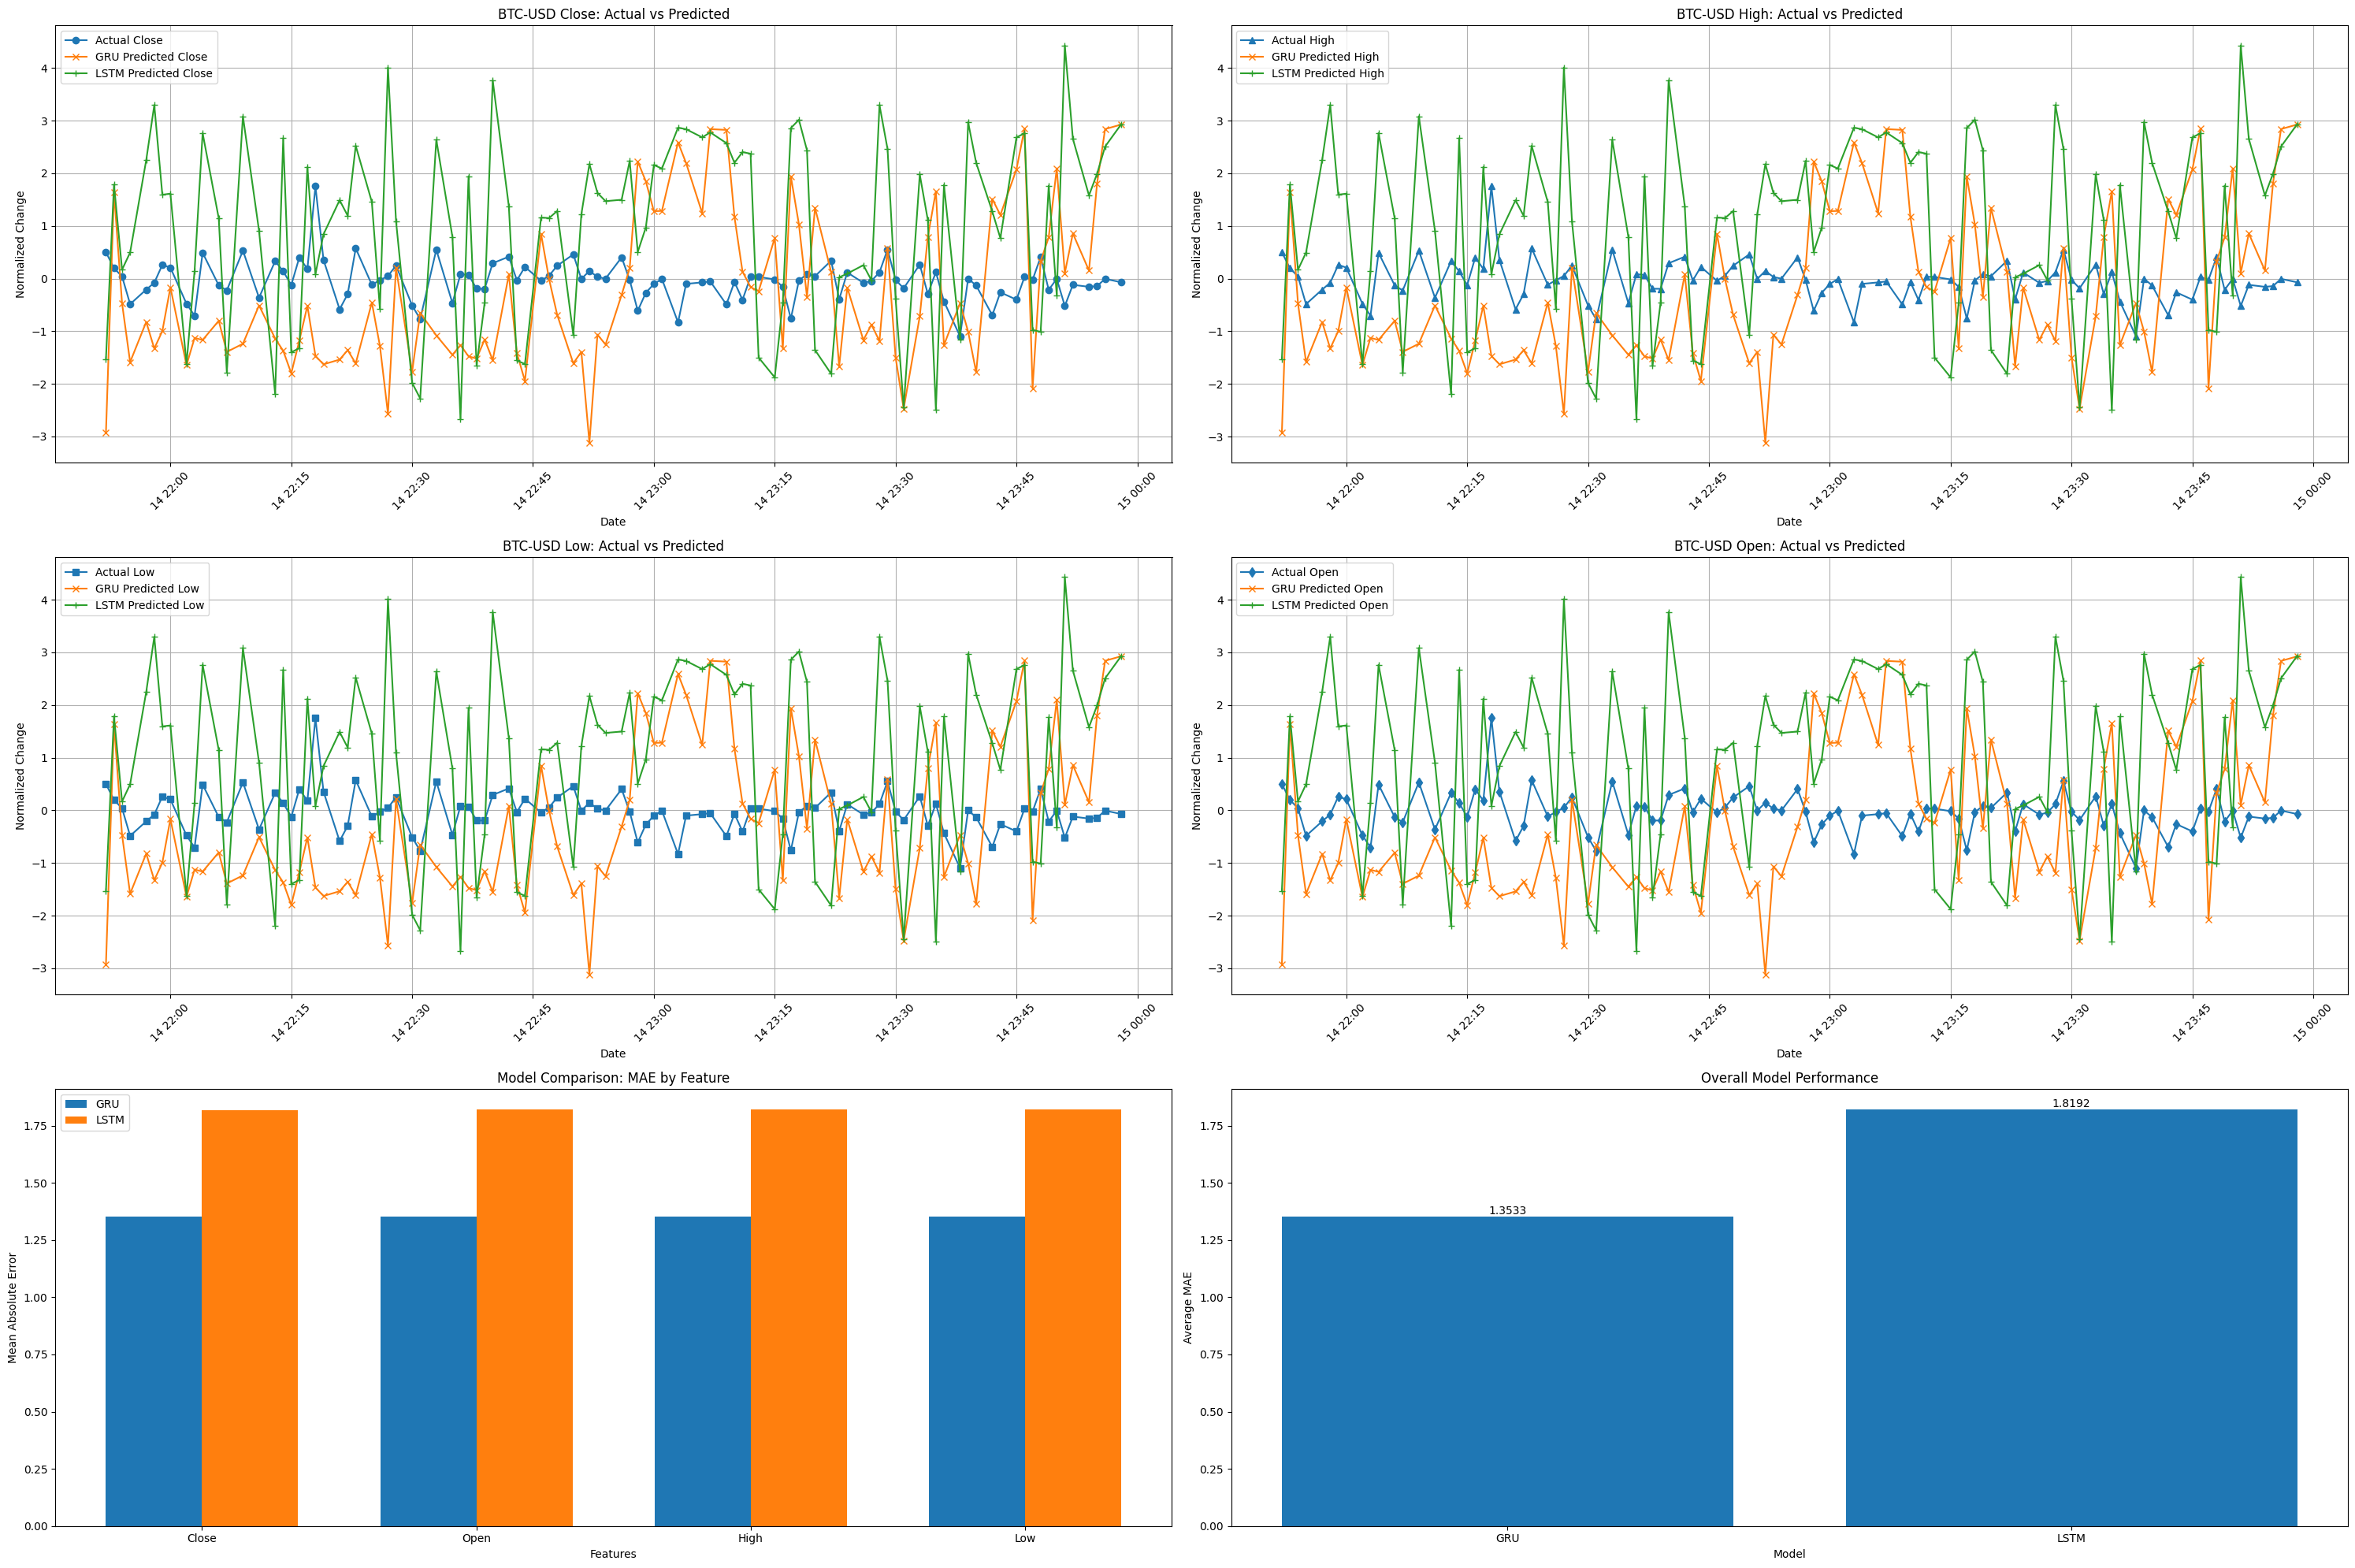

In [22]:
df_pred = result_df.copy()[-100:]
timeline = df_pred.index

# Create figure with 6 subplots (3 rows, 2 columns)
plt.figure(figsize=(30, 20))

# 1. Close Price
plt.subplot(3, 2, 1)
plt.plot(timeline, df_pred[f'Close_{ticker}'], label='Actual Close', marker='o')
plt.plot(timeline, df_pred[f'GRU_Pred_Close_{ticker}'], label='GRU Predicted Close', marker='x')
plt.plot(timeline, df_pred[f'LSTM_Pred_Close_{ticker}'], label='LSTM Predicted Close', marker='+')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} Close: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 2. High Price
plt.subplot(3, 2, 2)
plt.plot(timeline, df_pred[f'High_{ticker}'], label='Actual High', marker='^')
plt.plot(timeline, df_pred[f'GRU_Pred_High_{ticker}'], label='GRU Predicted High', marker='x')
plt.plot(timeline, df_pred[f'LSTM_Pred_High_{ticker}'], label='LSTM Predicted High', marker='+')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} High: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 3. Low Price
plt.subplot(3, 2, 3)
plt.plot(timeline, df_pred[f'Low_{ticker}'], label='Actual Low', marker='s')
plt.plot(timeline, df_pred[f'GRU_Pred_Low_{ticker}'], label='GRU Predicted Low', marker='x')
plt.plot(timeline, df_pred[f'LSTM_Pred_Low_{ticker}'], label='LSTM Predicted Low', marker='+')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} Low: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 4. Open Price
plt.subplot(3, 2, 4)
plt.plot(timeline, df_pred[f'Open_{ticker}'], label='Actual Open', marker='d')
plt.plot(timeline, df_pred[f'GRU_Pred_Open_{ticker}'], label='GRU Predicted Open', marker='x')
plt.plot(timeline, df_pred[f'LSTM_Pred_Open_{ticker}'], label='LSTM Predicted Open', marker='+')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} Open: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# 5. Model Comparison (MAE)
plt.subplot(3, 2, 5)
metrics = {
    'GRU': {
        'Close': np.mean(np.abs(df_pred[f'Close_{ticker}'] - df_pred[f'GRU_Pred_Close_{ticker}'])),
        'Open': np.mean(np.abs(df_pred[f'Open_{ticker}'] - df_pred[f'GRU_Pred_Open_{ticker}'])),
        'High': np.mean(np.abs(df_pred[f'High_{ticker}'] - df_pred[f'GRU_Pred_High_{ticker}'])),
        'Low': np.mean(np.abs(df_pred[f'Low_{ticker}'] - df_pred[f'GRU_Pred_Low_{ticker}']))
    },
    'LSTM': {
        'Close': np.mean(np.abs(df_pred[f'Close_{ticker}'] - df_pred[f'LSTM_Pred_Close_{ticker}'])),
        'Open': np.mean(np.abs(df_pred[f'Open_{ticker}'] - df_pred[f'LSTM_Pred_Open_{ticker}'])),
        'High': np.mean(np.abs(df_pred[f'High_{ticker}'] - df_pred[f'LSTM_Pred_High_{ticker}'])),
        'Low': np.mean(np.abs(df_pred[f'Low_{ticker}'] - df_pred[f'LSTM_Pred_Low_{ticker}']))
    }
}

features = ['Close', 'Open', 'High', 'Low']
x = np.arange(len(features))
width = 0.35

rects1 = plt.bar(x - width/2, [metrics['GRU'][f] for f in features], width, label='GRU')
rects2 = plt.bar(x + width/2, [metrics['LSTM'][f] for f in features], width, label='LSTM')

plt.xlabel('Features')
plt.ylabel('Mean Absolute Error')
plt.title('Model Comparison: MAE by Feature')
plt.xticks(x, features)
plt.legend()

# 6. Performance Summary
plt.subplot(3, 2, 6)
plt.axis('on')
avg_gru = np.mean([metrics['GRU'][f] for f in features])
avg_lstm = np.mean([metrics['LSTM'][f] for f in features])
plt.bar(['GRU', 'LSTM'], [avg_gru, avg_lstm])
plt.xlabel('Model')
plt.ylabel('Average MAE')
plt.title('Overall Model Performance')
for i, v in enumerate([avg_gru, avg_lstm]):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()

KeyError: 'Volume_BTC-USD'

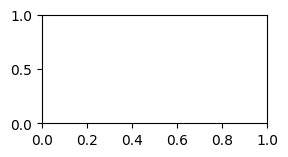

In [21]:
 # 5. Volume
plt.subplot(3, 2, 5)
plt.plot(timeline, df_pred[f'Volume_{ticker}'], label='Actual Volume', marker='*')
plt.plot(timeline, df_pred[f'Pred_Volume_{ticker}'], label='Predicted Volume', marker='x')
plt.xlabel('Date')
plt.ylabel('Normalized Change')
plt.title(f'{ticker} Volume: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)